In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
import sklearn.model_selection as skm
import sklearn.linear_model as skl
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
import math

In [2]:
from sklearn.tree import (DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn.linear_model import Ridge
from sklearn.metrics import (accuracy_score , mean_squared_error, r2_score,
log_loss)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from ISLP.models import \
(sklearn_selected ,
sklearn_selection_path)

In [3]:
!pip install l0bnb
from l0bnb import fit_path

# Load and Read the Dataset

In [7]:
df = pd.read_csv(r"C:\Users\ejbor\Data Science and BA - Jupyter Lab\song_popularity.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


# Data Cleaning

#### Check for duplicate song names and drop them

In [12]:
df.drop_duplicates(subset=["song_name", "song_popularity"], inplace=True)

#### Drop the song name column

In [15]:
df.drop(['song_name', 'key', 'audio_mode', 'time_signature'], axis=1, inplace=True)

In [17]:
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,167.060,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,105.256,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,123.881,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,122.444,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,172.011,0.574


#### Check for rows that have null values

In [20]:
null_vals = df.isnull().sum()
print(null_vals)

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
audio_valence       0
dtype: int64


In [22]:
df.dtypes

song_popularity       int64
song_duration_ms      int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
audio_valence       float64
dtype: object

# EDA

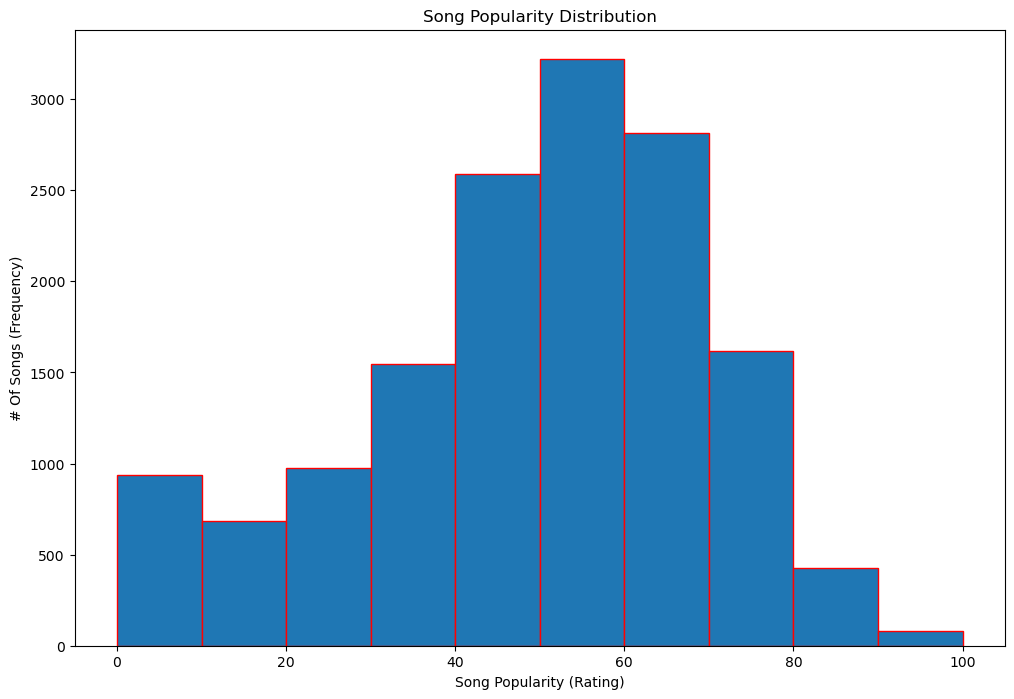

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

song_popularity_hist = plt.hist(df['song_popularity'].dropna(), edgecolor='red')
plt.title("Song Popularity Distribution")
plt.xlabel("Song Popularity (Rating)")
plt.ylabel("# Of Songs (Frequency)")
plt.show()

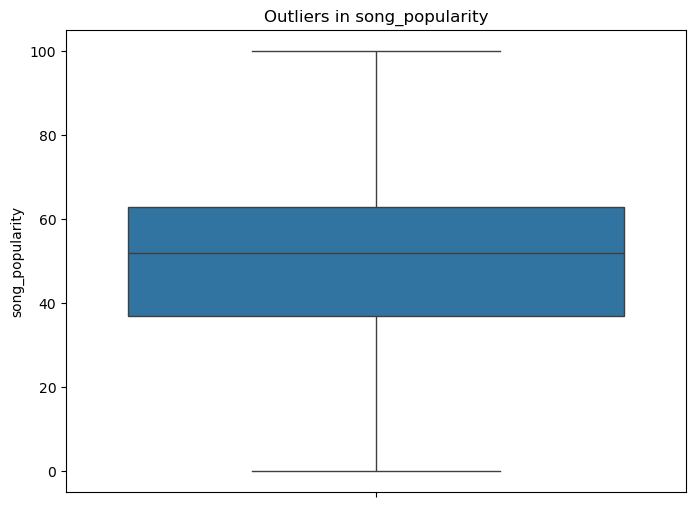

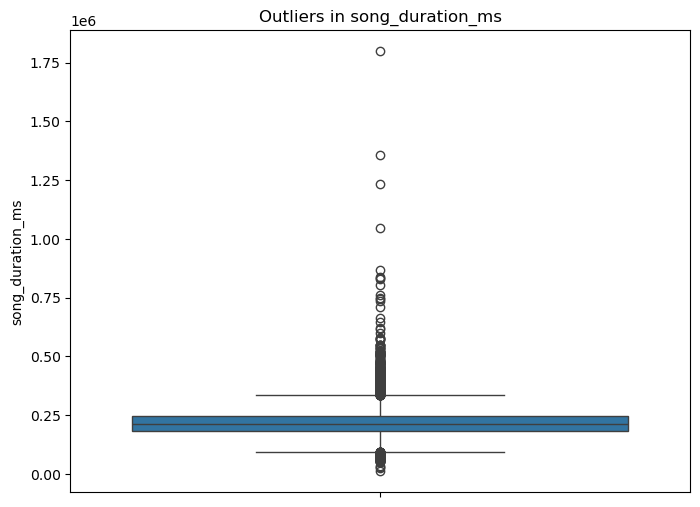

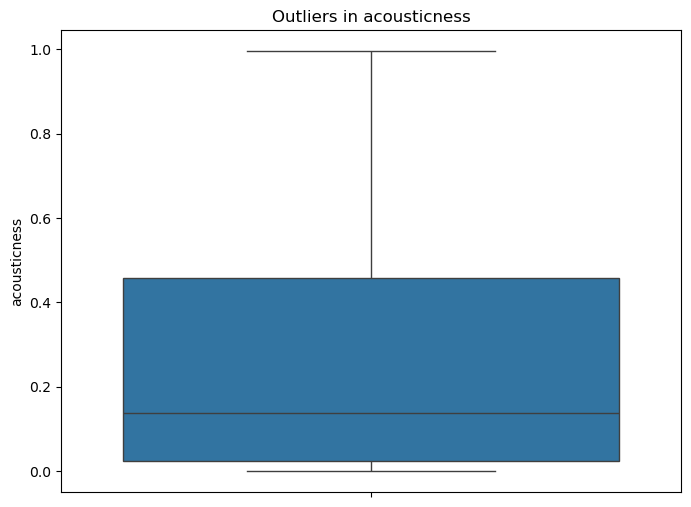

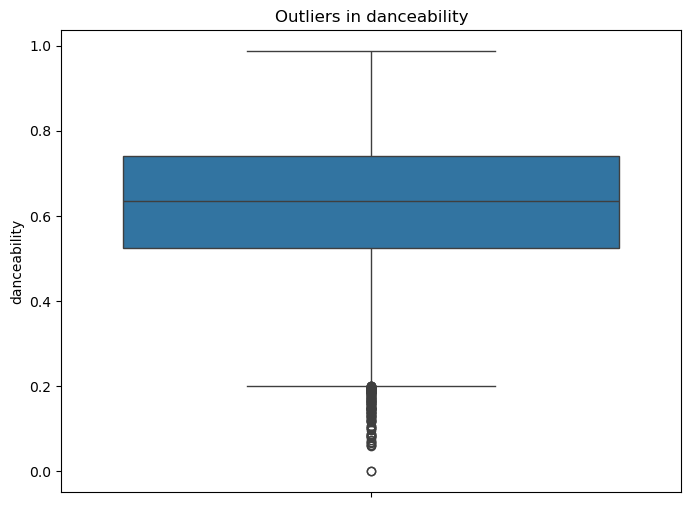

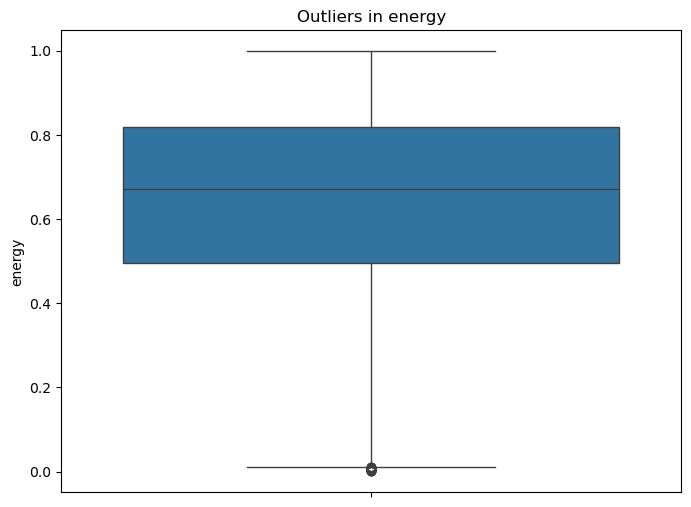

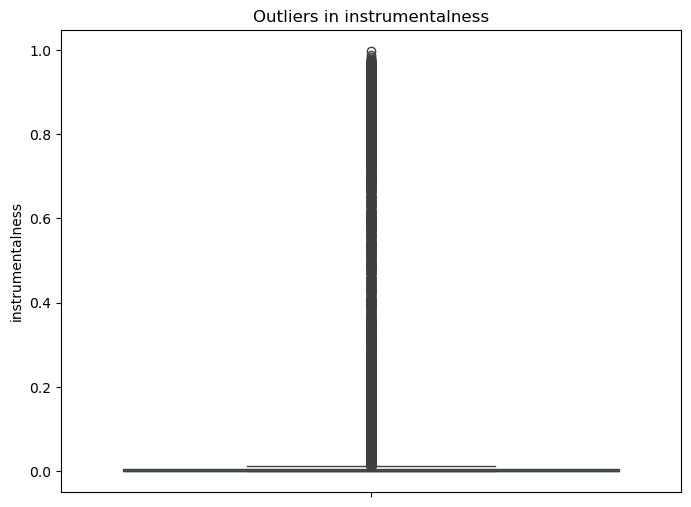

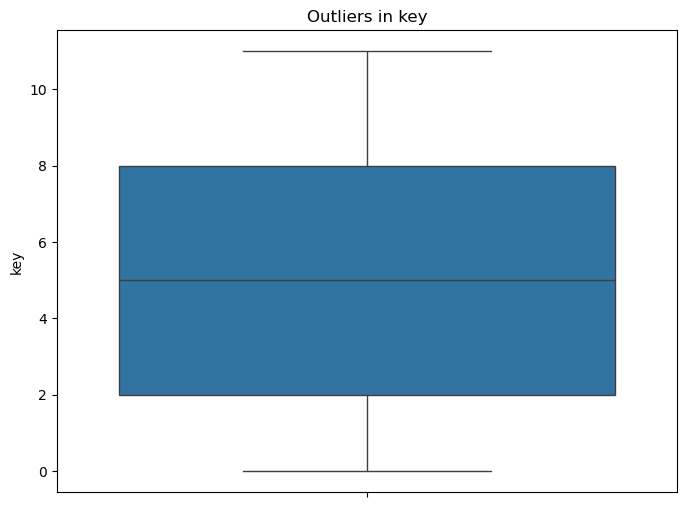

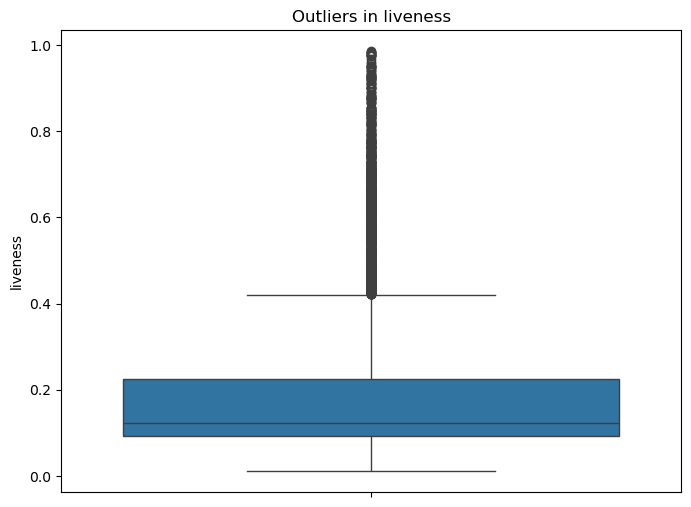

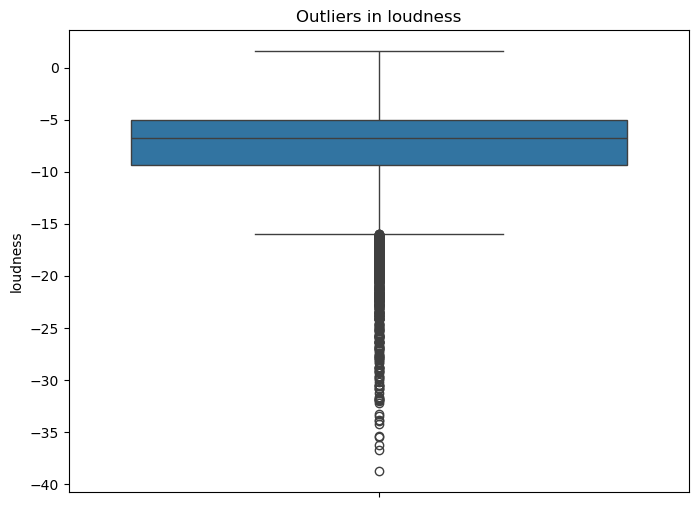

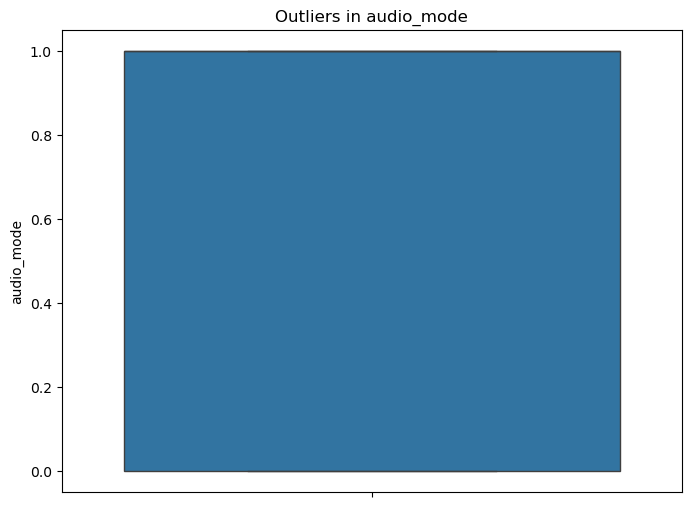

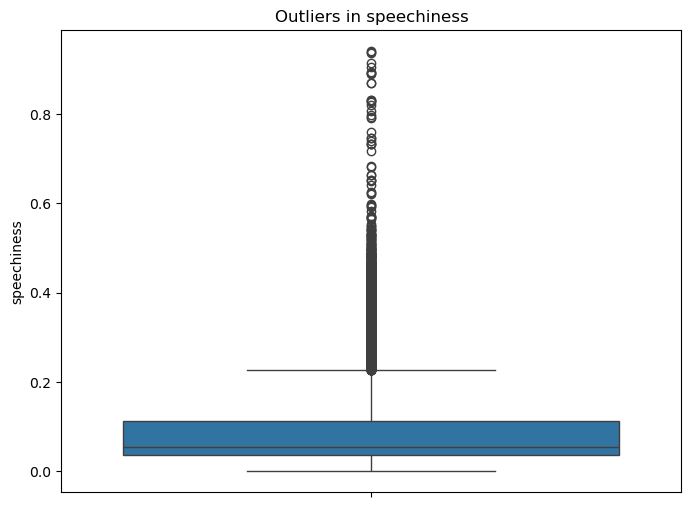

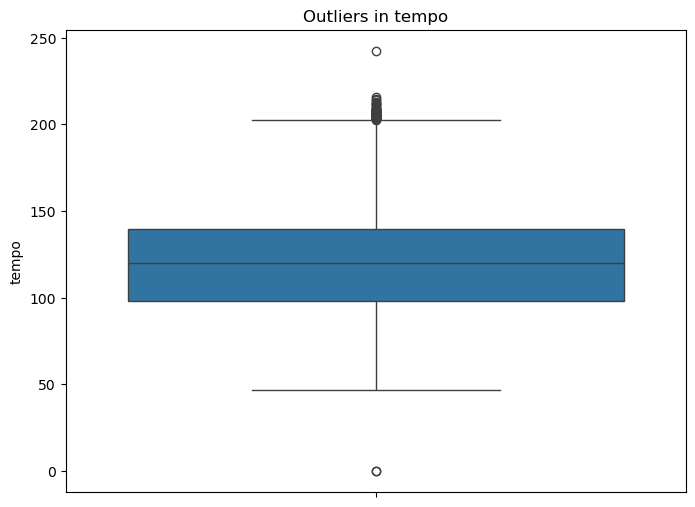

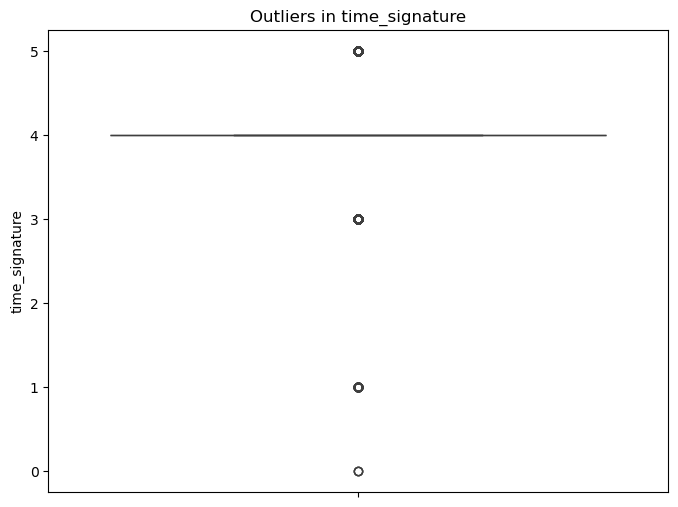

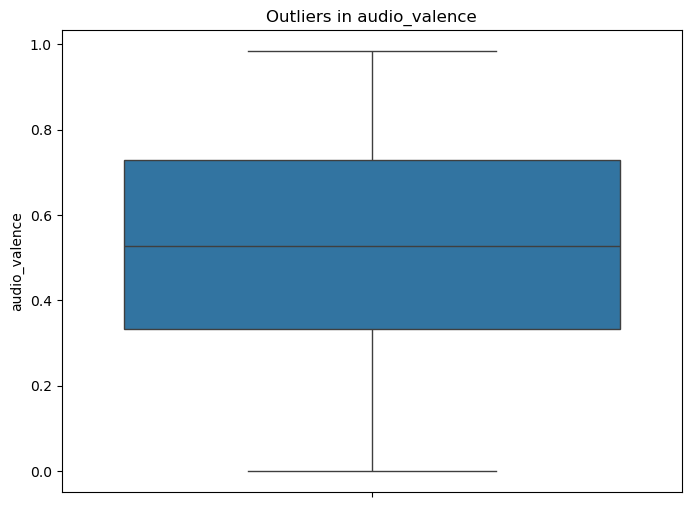

In [21]:
import seaborn as sns
columns_box_plot = ['song_popularity', 'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
                    'speechiness', 'tempo', 'time_signature', 'audio_valence']

for column in columns_box_plot:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=df[column])
        plt.title(f'Outliers in {column}')
        plt.show()
    else:
        print(f'Skipping non-numeric column: {column}')

# Modeling

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_standardized = scaler.fit_transform(df)

df= pd.DataFrame(df_standardized, columns=df.columns)

In [26]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['song_popularity'])
y = df['song_popularity']

results = {
    'Regression Tree': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Ridge Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Lasso Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Principal Component Regression (PCR)': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Regression Splines': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Support Vector Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []}
}
num_features = X.shape[1]

for _ in range(20):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

    
    models = {
        'Regression Tree': DecisionTreeRegressor(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Principal Component Regression (PCR)': make_pipeline(StandardScaler(), PCA(n_components=num_features), LinearRegression()),
        'Regression Splines': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'Support Vector Regression': SVR()
    }
    
    for model_name, model in models.items():
        
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
      
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rss = np.sum((y_test - y_pred) ** 2)
        rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))
        r2 = r2_score(y_test, y_pred)
        
        
        results[model_name]['Test MSE'].append(mse)
        results[model_name]['Test RMSE'].append(rmse)
        results[model_name]['Test RSE'].append(rse)
        results[model_name]['Test RSS'].append(rss)
        results[model_name]['Test R^2'].append(r2)

# Calculate average performance for each model
average_results = {model: {metric: np.mean(scores) for metric, scores in metrics.items()} for model, metrics in results.items()}

# Display results
results_df = pd.DataFrame(average_results).T
results_df


,Test MSE,Test RMSE,Test RSE,Test RSS,Test R^2
Regression Tree,1.923871,1.386981,1.388692,8597.781402,-0.931325
Ridge Regression,0.974791,0.987290,0.988507,4356.340660,0.021556
Lasso Regression,0.996599,0.998274,0.999505,4453.801112,-0.000330
Principal Component Regression (PCR),0.974791,0.987290,0.988507,4356.340868,0.021556
Regression Splines,0.990168,0.994773,0.996000,4425.059134,0.006003
Support Vector Regression,0.981039,0.990433,0.991654,4384.263287,0.015313


Running GridSearchCV for Ridge Regression...
Ridge Regression - Best Parameters: {'ridge__alpha': 100}
Ridge Regression - Metrics: {'MSE': 0.9770467520863501, 'RMSE': 0.9884567527648086, 'RSE': 0.989675497192343, 'RSS': 4366.421935073899, 'R²': 0.021618529356128846}



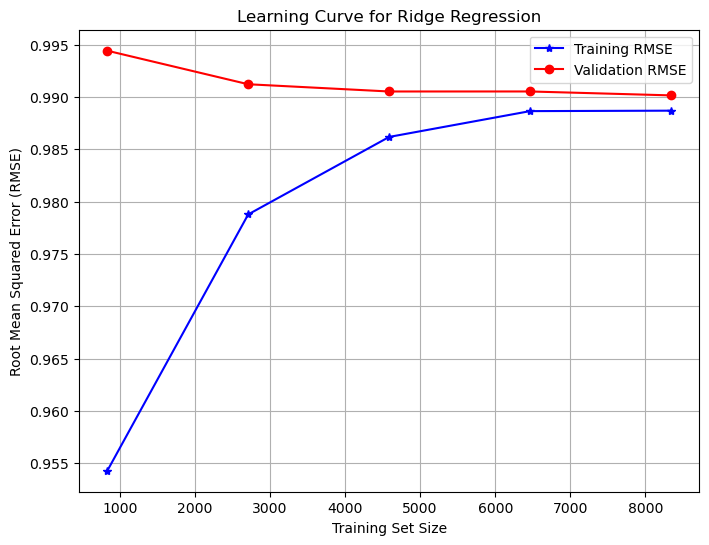

Running GridSearchCV for Lasso Regression...
Lasso Regression - Best Parameters: {'lasso__alpha': 0.01}
Lasso Regression - Metrics: {'MSE': 0.9807451822948902, 'RMSE': 0.9903257960362792, 'RSE': 0.9915468449511526, 'RSS': 4382.950219675864, 'R²': 0.0179150468167536}



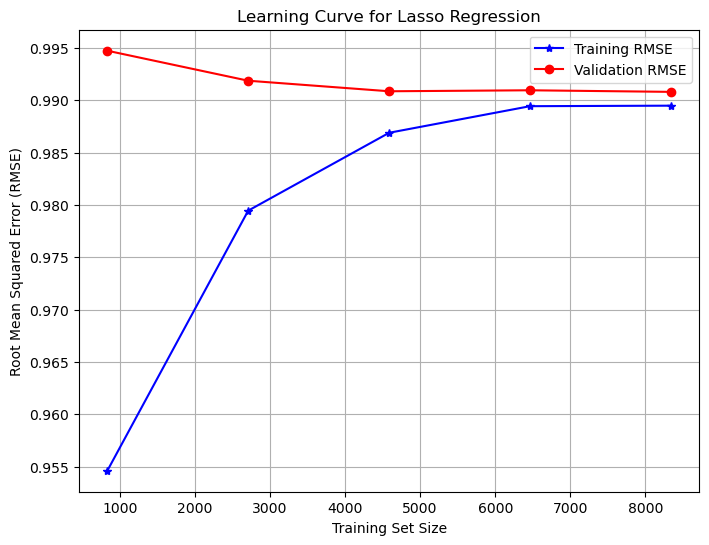

Running GridSearchCV for Principal Component Regression (PCR)...
Principal Component Regression (PCR) - Best Parameters: {'pca__n_components': 10}
Principal Component Regression (PCR) - Metrics: {'MSE': 0.9769576813041174, 'RMSE': 0.9884116962602767, 'RSE': 0.9896303851341778, 'RSS': 4366.023877748101, 'R²': 0.02170772181567704}



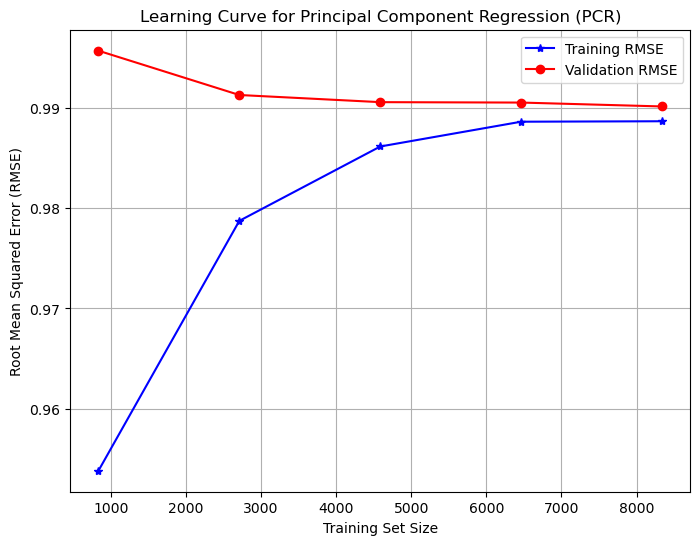

Running GridSearchCV for Regression Splines...
Regression Splines - Best Parameters: {'polynomialfeatures__degree': 2}
Regression Splines - Metrics: {'MSE': 0.9463578640795494, 'RMSE': 0.9728092639770395, 'RSE': 0.9740087154110143, 'RSS': 4229.273294571506, 'R²': 0.0523493406672596}



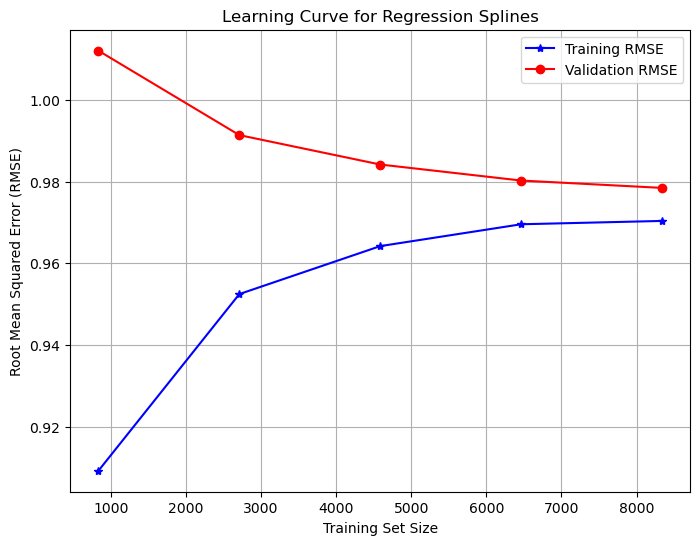

Running GridSearchCV for Regression Tree...
Regression Tree - Best Parameters: {'decisiontreeregressor__max_depth': 3, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}
Regression Tree - Metrics: {'MSE': 0.9667530843829386, 'RMSE': 0.9832360267926205, 'RSE': 0.9844483341851823, 'RSS': 4320.419534107353, 'R²': 0.03192625897549195}



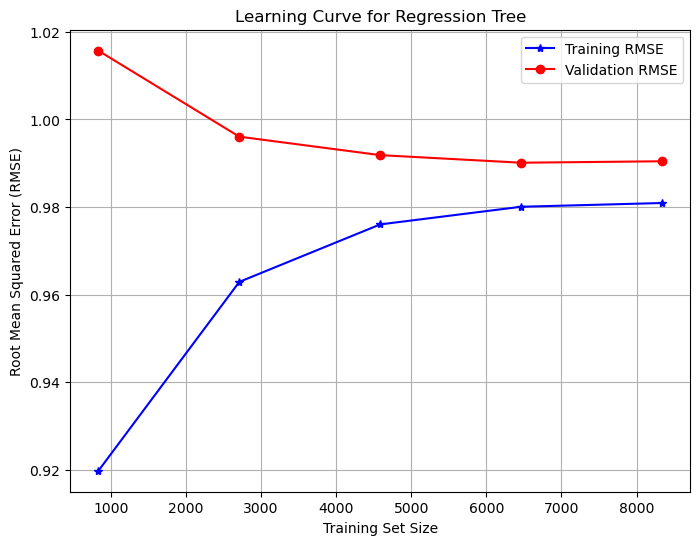

Running GridSearchCV for Support Vector Regression (SVR)...
Support Vector Regression (SVR) - Best Parameters: {'svr__C': 0.1, 'svr__epsilon': 1}
Support Vector Regression (SVR) - Metrics: {'MSE': 0.9477392674585147, 'RMSE': 0.9735190123764993, 'RSE': 0.9747193389139163, 'RSS': 4235.446786272102, 'R²': 0.050966050188499534}



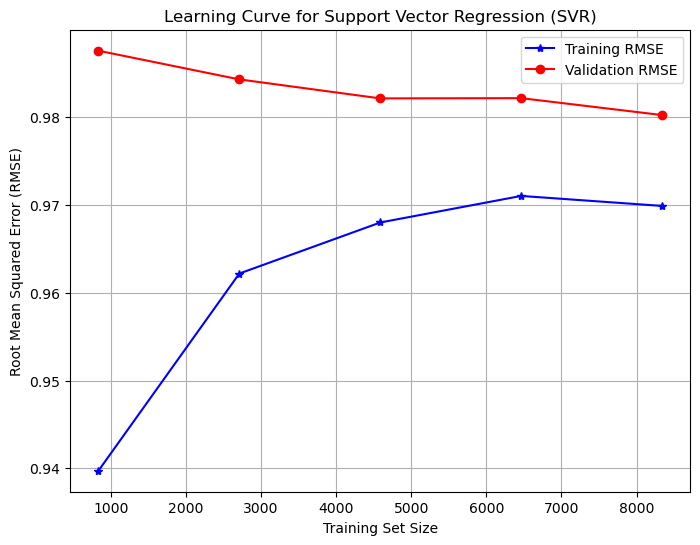


Model Performance Metrics:
                                           MSE      RMSE       RSE  \
Ridge Regression                      0.977047  0.988457  0.989675   
Lasso Regression                      0.980745  0.990326  0.991547   
Principal Component Regression (PCR)  0.976958  0.988412  0.989630   
Regression Splines                    0.946358  0.972809  0.974009   
Regression Tree                       0.966753  0.983236  0.984448   
Support Vector Regression (SVR)       0.947739  0.973519  0.974719   

                                              RSS        R²  
Ridge Regression                      4366.421935  0.021619  
Lasso Regression                      4382.950220  0.017915  
Principal Component Regression (PCR)  4366.023878  0.021708  
Regression Splines                    4229.273295  0.052349  
Regression Tree                       4320.419534  0.031926  
Support Vector Regression (SVR)       4235.446786  0.050966  

Best Parameters for Each Model:
Ridge Regressi

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Ridge Regression': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'lasso__alpha': [0.01, 0.1, 1, 10, 100]},
    'Principal Component Regression (PCR)': {'pca__n_components': [1, 2, 3, 4, X.shape[1]]},
    'Regression Splines': {'polynomialfeatures__degree': [2, 3, 4]},
    'Regression Tree': {
      'decisiontreeregressor__max_depth': [3, 4, 5],
      'decisiontreeregressor__min_samples_split': [10, 15, 20],
      'decisiontreeregressor__min_samples_leaf': [4, 8, 10]
},
    'Support Vector Regression (SVR)': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.1, 0.5, 1]}
}



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rss = np.sum((y_true - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_true) - n_features - 1))
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'RSE': rse, 'RSS': rss, 'R²': r2}

# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='*', color='blue')
    plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='o', color='red')
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.legend()
    plt.grid()
    plt.show()

# Dictionary to store results
results = {}
best_parameters = {}

# Iterate over each model and perform GridSearchCV
for model_name, grid_params in param_grids.items():
    print(f"Running GridSearchCV for {model_name}...")
    
    # Define the model pipeline
    if model_name == 'Principal Component Regression (PCR)':
        model = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    elif model_name == 'Regression Splines':
        model = make_pipeline(PolynomialFeatures(), LinearRegression())
    elif model_name == 'Ridge Regression':
        model = make_pipeline(StandardScaler(), Ridge(max_iter=5000))
    elif model_name == 'Lasso Regression':
        model = make_pipeline(StandardScaler(), Lasso(max_iter=5000))
    elif model_name == 'Regression Tree':
        model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
    elif model_name == 'Support Vector Regression (SVR)':
        model = make_pipeline(StandardScaler(), SVR())

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store the best parameters
    best_parameters[model_name] = grid_search.best_params_
    
    # Predict on the test set using the best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate performance metrics
    metrics = calculate_metrics(y_test, y_pred, X_test_scaled.shape[1])
    results[model_name] = metrics

    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Metrics: {metrics}\n")

    # Plot learning curve for the best model
    plot_learning_curve(best_model, X_train_scaled, y_train, model_name)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)

# Display best parameters for each model
print("\nBest Parameters for Each Model:")
for model_name, params in best_parameters.items():
    print(f"{model_name}: {params}")